<a href="https://colab.research.google.com/github/Mukiti-Ryan/Palmer_Penguins_Decision_Trees/blob/main/Palmer_Penguin_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries
---
In this case, we will use TensorFlow Decision Forests Library to train, tune, and interpret a decision tree


In [ ]:
!pip install tensorflow_decision_forests -q
!pip install keras-tuner -q

import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
import keras_tuner as kt

Palmer Penguins Dataset
---
We will use the Palmer Penguins dataset which contains size measurements for three penguin species.

This is a classification problem and the goal is to predict the species of the penguin based on data found in the Palmer's Penguin dataset

The **pandas** function is used to load the dataset into memory

In [ ]:
path = "https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv"
pandas_dataset = pd.read_csv(path)

pandas_dataset.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


The full dataset contains a mix of numerical (for example, **bill_depth_mm**), categorical (for example **island**), and missing features.

Unlike neural networks, decision forests support all these feature types natively, so you do not hvae to do **one-hot encoding**, **normalization**, or extra **is_present** feature.

To simplify interpretability, the code cell below manually converts the penguin species into interger labels.

In [ ]:
label = "species"

classes = list(pandas_dataset[label].unique())
print(f"Label classes: {classes}")

pandas_dataset[label] = pandas_dataset[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


The Code cell below splits the dataset into a training set and testing set.

We use ~10% of the examples as the testing set and the remaining ~90% of the examples as the training set.

In [ ]:
np.random.seed(1)

test_indices = np.random.rand(len(pandas_dataset)) < 0.1
pandas_train_dataset = pandas_dataset[~test_indices]
pandas_test_dataset = pandas_dataset[test_indices]

print("Training examples: ", len(pandas_train_dataset))

print("Testing examples: ", len(pandas_test_dataset))

Training examples:  309
Testing examples:  35


Training a model with default hyperparameters
---
We can train our first **CART (Classification and Regression Trees)** model without specifying any hyperparameters. That's because the **tfdf.keras.CartModel** function provides good default hyperparameter values.


In [ ]:
tf_train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pandas_train_dataset, label = label)
model = tfdf.keras.CartModel()
model.fit(tf_train_dataset)

Use /tmp/tmp3tp3d8pe as temporary training directory
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:06.500399. Found 309 examples.
Training model...
Model trained in 0:00:00.055253
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


The preceding call to **tfdf.keras.CartModel** did not specify columns to use as input features.

Therefore, every column in the training set is used. The call also did not specify the semantics (for example, numerical, categorical, text) of the input features.

Therefore, **tfdf.keras.CartModel** will automatically infer the semantics.


Visualization of a decision tree in colab
---

The call **tfdf.model_plotter.plot_model_in_colab** is used to display the resulting decision tree.

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, max_depth = 10)

The above visualiztion indicates that the root condition evaluated 277 examples. However, you might remember that the training dataset contained 309 examples. The remaining 32 examples were used for validation.

The first condition tests the value of **bill_depth_mm**.

The tables below show the likelihood of different species depending on the outcome of the first condition.

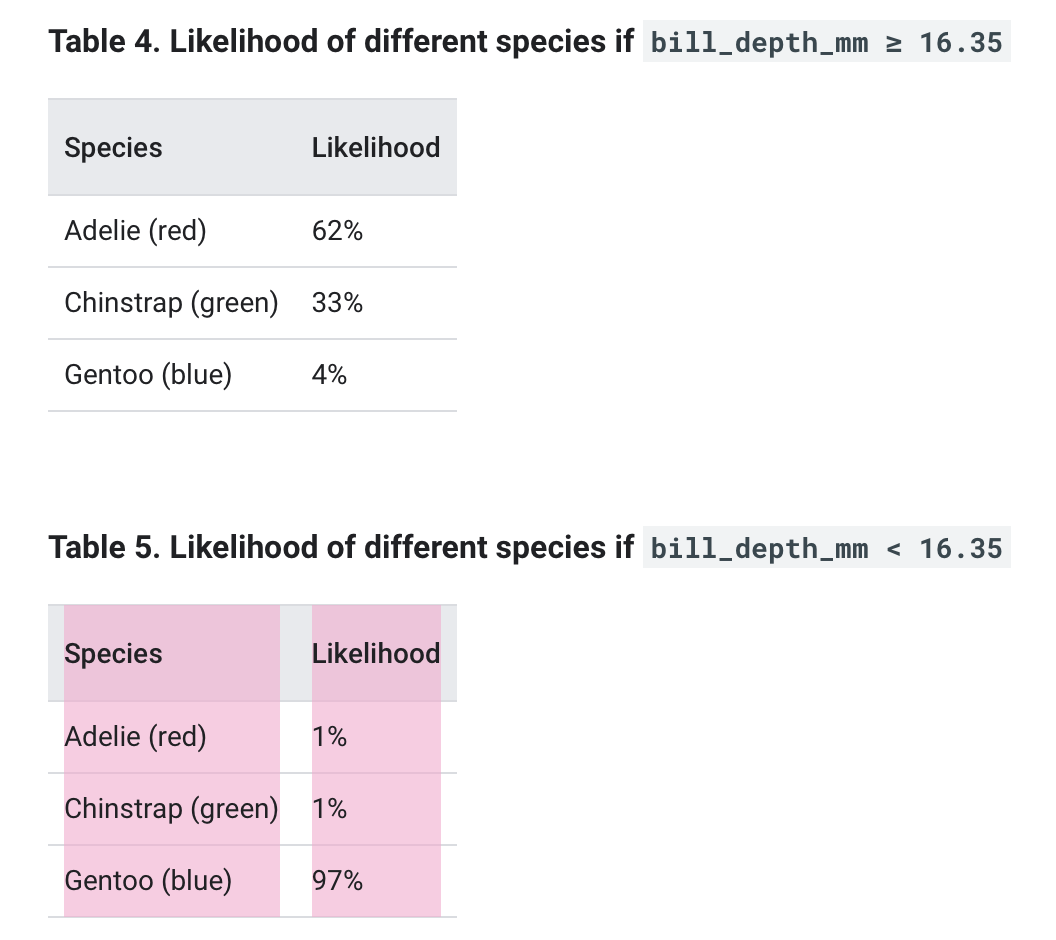

**bill_depth_mm** is a numerical feature. Therefore, the value 16.35 was found using the exact splitting for binary classification with numerical features algorithm. `https://developers.google.com/machine-learning/decision-forests/binary-classification`

If **bill_depth_mm < 16.5** is True, further testing whether the **body_mass_g >= 4175** can perfectly separate between 86 gentoos and 5 Gentoos + Adelie

The following code provides the training and test accuracy of the model.

It is rare, but possible, that the test accuracy is higher than the training accuracy. In that case, the test set possibly differs from the training set. However, this is not te case here as the train/test set was split randomly. A more likely explanation is that the test dataset is very small, so the accuracy estimation is noisy.

In [ ]:
model.compile("accuracy")
print("Train evaluation: ", model.evaluate(tf_train_dataset, return_dict = True))

tf_test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pandas_test_dataset, label = label)
print("Test evaluation: ", model.evaluate(tf_test_dataset, return_dict = True))

1/1 [==============================] - 1s 697ms/step - loss: 0.0000e+00 - accuracy: 0.9709
Train evaluation:  {'loss': 0.0, 'accuracy': 0.9708737730979919}
1/1 [==============================] - 0s 286ms/step - loss: 0.0000e+00 - accuracy: 0.9714
Test evaluation:  {'loss': 0.0, 'accuracy': 0.9714285731315613}


To train a better model, optimize the hyperparameters with the **Keras Tuner**

Important note: Don't tune hyperparameters on the test dataset. Instead, tune hyperparameters on a separate validation dataset (on large datasets) or using cross-validation (on small datasets). For simplicity, this course uses the test dataset for tuning.

The following code optimizes two parameters:

1.   The minimum number of examples in a condition node (min_examples)
2.   The ratio of the training dataset used for pruning validation (validation_ratio)

Since we don't know the best values for these parameters, we provide various possibilities for the tuner to try. We've picked four possible values for min_examples and three for validation_ratio. Increasing the number of candidate hyperparameter values increases the chance of training a better model, but it also increases the training time.

In [ ]:
def build_model(hp):
  model = tfdf.keras.CartModel(
      # Try four possible values for "min_examples" hyperparameter.
      # min_examples=10 would limit the growth of the decision tree,
      # while min_examples=1 would lead to deeper decision trees.
      min_examples = hp.Choice("min_examples", [1, 2, 4, 10]),
      # Three possible values for the "validation_ratio" hyperparameter.
      validation_ratio = hp.Choice("validation_ratio", [0.0, 0.05, 0.10]),
  )
  model.compile("accuracy")
  return model

tuner = kt.RandomSearch(
      build_model,
      objective = "val_accuracy",
      max_trials = 10,
      directory = "/tmp/tuner",
      project_name = "tune_cart")
  
tuner.search(x = tf_train_dataset, validation_data = tf_test_dataset)
best_model = tuner.get_best_models()[0]

print("Best hyperparameters: ", tuner.get_best_hyperparameters()[0].values)

Use /tmp/tmpikg0g49c as temporary training directory
Best hyperparameters:  {'min_examples': 2, 'validation_ratio': 0.0}


The candidate values of the hyperparameter depend on your understanding of the dataset and the amount of computing resources available.

The following code retrains and evaluates the model using those optimized hyperparameters

In [ ]:
model = tfdf.keras.CartModel(min_examples = 2, validation_ratio = 0.0)
model.fit(tf_train_dataset)

model.compile("accuracy")
print("Test evaluation: ", model.evaluate(tf_test_dataset, return_dict = True))

Use /tmp/tmpd8kibcb9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.430583. Found 309 examples.
Training model...
Model trained in 0:00:00.041140
Compiling model...
Model compiled.
1/1 [==============================] - 0s 164ms/step - loss: 0.0000e+00 - accuracy: 0.9714
Test evaluation:  {'loss': 0.0, 'accuracy': 0.9714285731315613}


The accuracy of 0.9714 means our model perfectly explains our test dataset in this toy example

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, max_depth = 10)

As expected by the new hyperparameter values, the decision tree is deeper than before because:

1.   The minimum number of examples was reduced **(from 5 to 2).**
2.  Validation pruning was disabled **(validation_ratio = 0.0)** leading to  more available training examples and no pruning.

Usage and Limitation
---
As mentioned earlier, a single decision tree often has lower quality than modern machine learning methods like random forests, gradient boosted trees, and neural networks. However, decision trees are still useful in the following cases:


1. As simple and inexpensive baseline to evaluate more complex approaches.
2. When there is tradeooff between the model quality and interpretability.
3. As a proxy for the interpretation of the decision forests model.



